In [1]:
import json
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import requests
import seaborn as sns
from IPython.display import display
from matplotlib.cbook import boxplot_stats
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from utils.preprocessing_utils import (clean_labs, clean_notas,
                                       clean_sociodemograficos,
                                       disease_tests_list, remove_characters,
                                       remove_stop_words, strip_accents)


2022-07-07 12:23:40.100031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 12:23:40.100072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/juanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Notebook configuration

In [2]:
sns.set_style("whitegrid")
sns.set_context("talk")

png_renderer = pio.renderers["png"]
fig_width = 1280
fig_height = 720
png_renderer.width = fig_width
png_renderer.height = fig_height

pio.renderers.default = "png"

cleaning_dict_path = "utils/lab_test_name_aggregation.json"
eda_save_path = Path("data") / "output" / "EDA"
summary_files_save_path = Path("utils") / "api_data"
figure_save_path = eda_save_path / "figures"
summary_files_save_path.mkdir(parents=True, exist_ok=True)
figure_save_path.mkdir(parents=True, exist_ok=True)


In [3]:
def download_file(url: str, local_filename: Optional[str] = None):
    if local_filename is None:
        local_filename = url.split("/")[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    return local_filename


def unzip_file(path_to_zip_file: str, directory_to_extract_to: str):
    shutil.unpack_archive(path_to_zip_file, directory_to_extract_to)


In [4]:
# Check if the data already exists, if not, download and unzip it
data_path = Path("data")
if (
    not (data_path / "laboratorios.csv").is_file()
    and not (data_path / "notas.csv").is_file()
    and not (data_path / "sociodemografico.csv").is_file()
):
    data_zip = download_file(
        "https://www.dropbox.com/sh/xgs3kyvyn7lmr6p/AACB4eORnqsJpRsjv9-56eUHa?dl=1",
        "data.zip",
    )
    unzip_file(data_zip, data_path)
    unzip_file(
        data_path / "Diana Buitrago - IQVIA_NLPmediaclNotes_DianaBuitrago.zip",
        data_path,
    )


In [5]:
# Check if the data already exists, if not, download and unzip it
data_path = Path("data")
if (
    not (data_path / "laboratorios.csv").is_file()
    and not (data_path / "notas.csv").is_file()
    and not (data_path / "sociodemografico.csv").is_file()
):
    data_zip = download_file(
        "https://www.dropbox.com/sh/xgs3kyvyn7lmr6p/AACB4eORnqsJpRsjv9-56eUHa?dl=1",
        "data/data.zip",
    )
    unzip_file(data_zip, data_path)
    unzip_file(
        data_path / "Diana Buitrago - IQVIA_NLPmediaclNotes_DianaBuitrago.zip",
        data_path,
    )


## Load Data

In [6]:
notas = pd.read_csv(str(data_path / "notas.csv"), sep=";")
notas.head()


,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [7]:
sociodemografico = pd.read_csv(str(data_path / "sociodemografico.csv"), sep=";")
sociodemografico.head()


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [8]:
laboratorios = pd.read_csv(str(data_path / "laboratorios.csv"), sep=";")
laboratorios.head()


,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


### Cleanup based on initial EDA

In [9]:
with open(cleaning_dict_path, "r") as in_file:
    dict_tests = json.load(in_file)

laboratorios = clean_labs(laboratorios, name_aggregation_dict=dict_tests)


In [10]:
notas = clean_notas(notas)
notas.head()


,IDRecord,Código,Nombre,Tipo,Plan
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACION Se brinda retroalimentacion con rel...


In [11]:
sociodemografico = clean_sociodemograficos(sociodemografico)
sociodemografico.head()


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [12]:
merged = sociodemografico.merge(notas, how="inner", on="IDRecord")
merged.head(5)


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...


Merge the laboratory with the medical notes data, to get the disease tied to the Lab IDRecord. Use unduplicated data for the lab info so we don't get duplicated information

In [13]:
merged_lab = laboratorios.merge(
    notas[["IDRecord", "Código", "Nombre"]].drop_duplicates(subset="IDRecord"),
    how="inner",
    on="IDRecord",
    suffixes=["_lab", None],
)
merged_lab.head(5)


,IDRecord,Codigo,Nombre_lab,Fecha,Valor,fecha,Código,Nombre
0,95627,902045,tiempo de protrombina (pt),22/02/2022 18:43,NaN,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
1,95627,902049,tiempo de tromboplastina parcial (ptt),22/02/2022 18:43,37.1,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
2,95627,903803,albumina test,22/02/2022 18:43,4.0,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
3,95627,903809,bilirrubina test,22/02/2022 18:43,NaN,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
4,95627,902209,"hemograma iii (hemoglobina, hematocrito, recue...",22/02/2022 18:43,NaN,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."


 # Sociodemographic vs medical notes EDA

In [14]:
# Lets first translate the names of the features so they look nicer on the charts
spa_eng_dict = {
    "Edad": "Age",
    "Código": "Code",
    "TSangre": "Blood_Type",
    "EstadoCivil": "Marital_Status",
    "GrupoEtnico": "Ethnic_Group",
    "Genero": "Gender",
    "AreaResidencial": "Residential_Area",
}
eng_spa_dict = {v: k for k, v in spa_eng_dict.items()}

merged_translated = merged.rename(columns=spa_eng_dict).fillna("N/A")

merged_translated = merged_translated.drop_duplicates(
    subset=["IDRecord"]
)  # Uncomment this line to get the EDA per unique patient instead of per total EHR data
merged_translated


,IDRecord,Age,Gender,Ethnic_Group,Residential_Area,Marital_Status,Blood_Type,Code,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,N/A,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,N/A,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
14,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,N/A,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1) Se dan instrucciones sobre cuidados general...
18,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,N/A,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,Visita medica fallida: Se desplaza hasta la ve...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,N/A,N/A,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"se explica acerca del programa, Se recomienda ..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente al diagnostico. Ref...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,N/A,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL POR CADA FOSA ...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,N/A,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO EN UN MES-INFECTOLOGIA VALORACI...


In [15]:
# Define an auxiliary function
def percentage_for_code(df, row):
    count = row["Count"]
    total_for_code = df[df.Code == row["Code"]].Count.sum()
    return round(100 * count / total_for_code, 2)


## Age vs Code Histogram

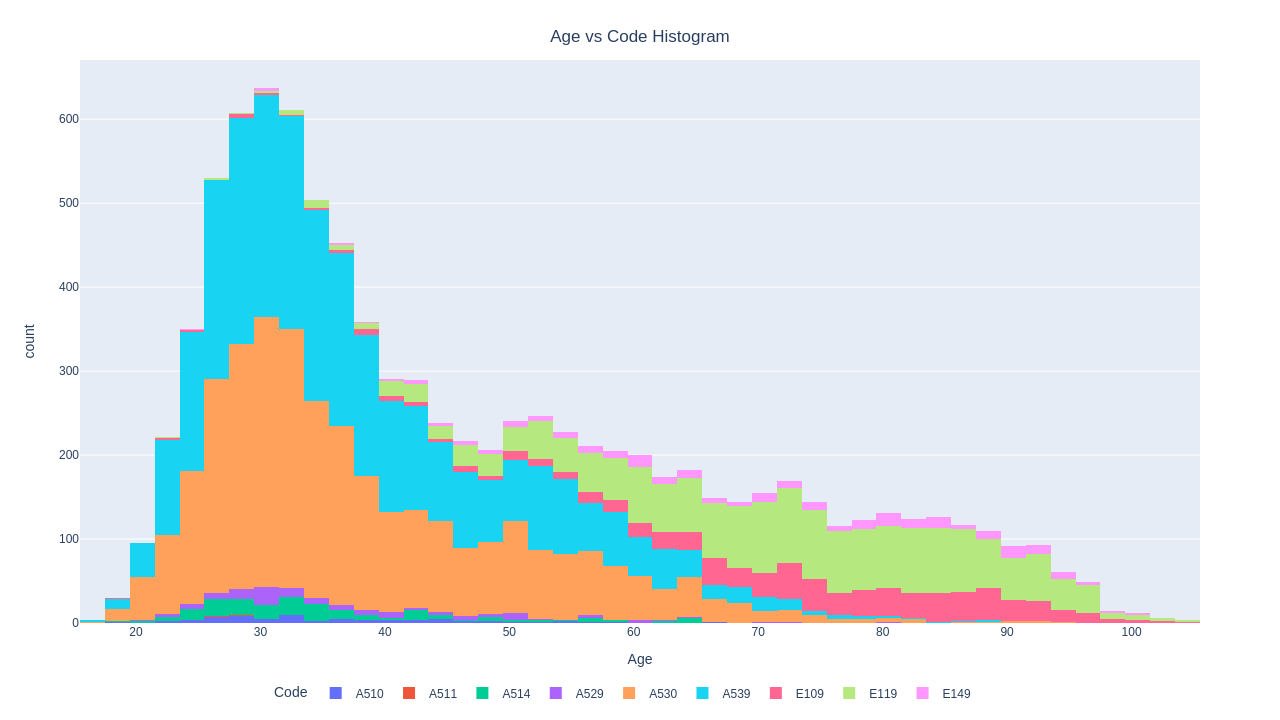

In [16]:
var_of_interest = "Age"

fig = px.histogram(
    merged_translated.sort_values(by="Code"),
    x=var_of_interest,
    color="Code",
    labels={
        "count": "Count",
    },
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="right",
        x=0.8,
    ),
    title={
        "text": f"{var_of_interest} vs Code Histogram",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)',
)

fig.show()
fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_histogram.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)


## Age vs Code Boxplot

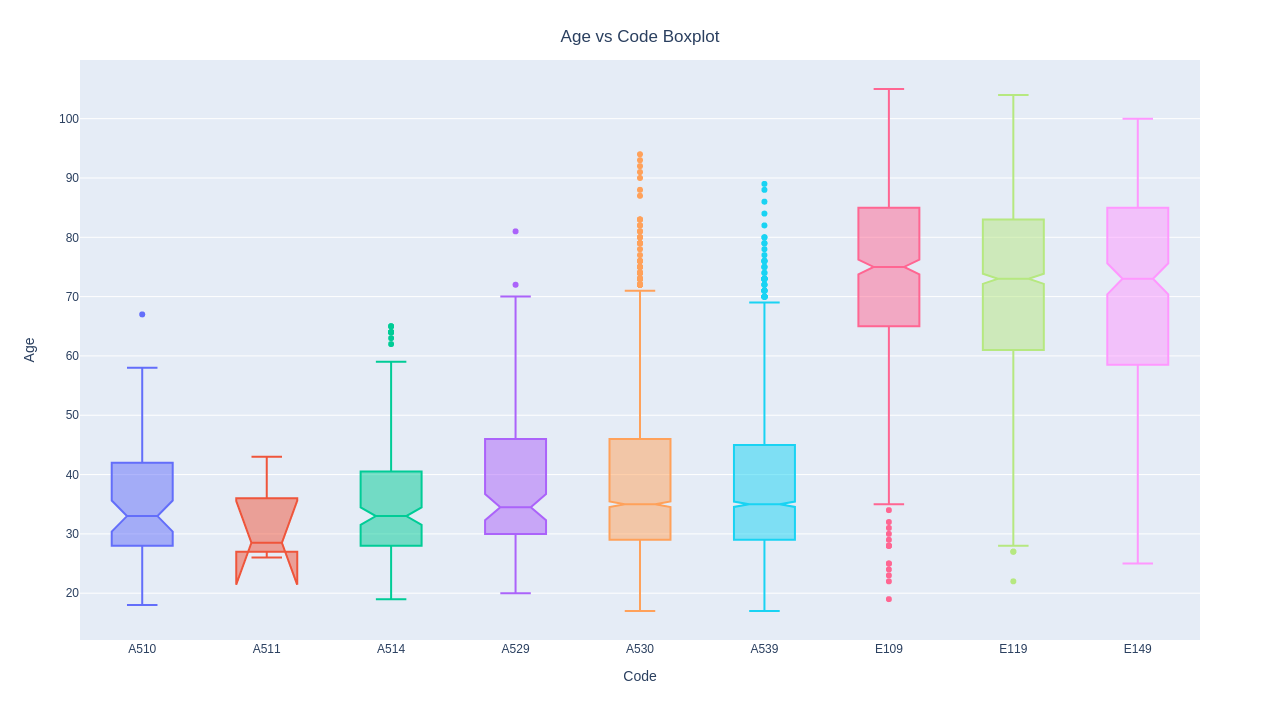

In [17]:
var_of_interest = "Age"

fig = px.box(
    merged_translated.sort_values(by="Code"),
    y=var_of_interest,
    x="Code",
    color="Code",
    notched=True,
)

fig.update_layout(
    showlegend=False,
    title={
        "text": f"{var_of_interest} vs Code Boxplot",
        # 'y':0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


We can see that there is quite the disparity between the average ages of people suffering from syphilis, and those suffering from diabetes. This was also noted in the literature review, where we found that syphilis affects a younger population, specially compared to diabetes.

## Gender vs Code Bar Graph

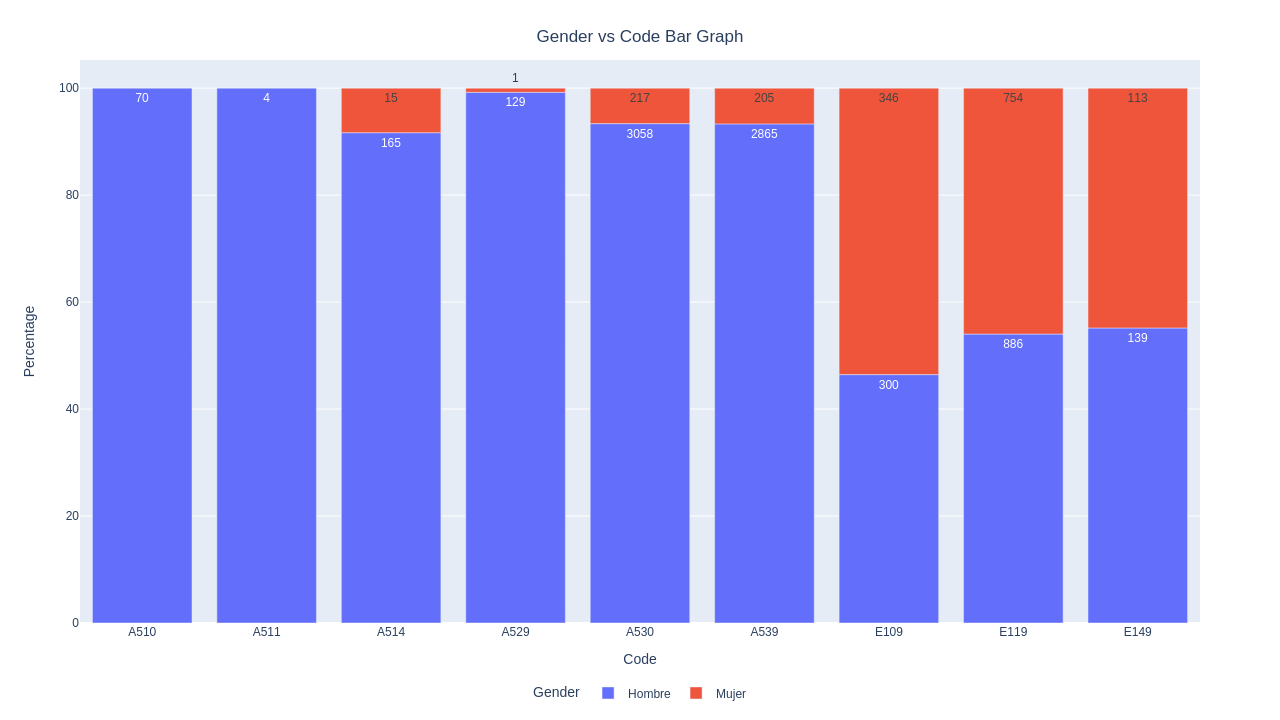

In [18]:
var_of_interest = "Gender"

df_analysis = (
    merged_translated[["Nombre", "Code", var_of_interest]]
    .value_counts()
    .to_frame("Count")
)
df_analysis["Percentage"] = (df_analysis.Count / sum(df_analysis.Count) * 100).round(2)
df_analysis.sort_values(["Code", "Count"], ascending=False)

df_analysis = df_analysis.reset_index()
df_analysis["Percentage"] = df_analysis.apply(
    lambda row: percentage_for_code(df_analysis, row), axis=1
)
df_analysis = df_analysis.sort_values(["Code"])

fig = px.bar(
    df_analysis,
    x="Code",
    y=["Percentage"],
    color=var_of_interest,
    text=df_analysis["Count"],
    labels={
        "value": "Percentage",
    },
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="right",
        x=0.6,
    ),
    xaxis={"categoryorder": "category ascending"},
    title={
        "text": f"{var_of_interest} vs Code Bar Graph",
        # 'y':0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


Gender also seems to be a differentiating characteristic for syphilis and diabetes diagnoses, which again was a correlation found on our literature review.

## Ethnic Group vs Code Bar Graph

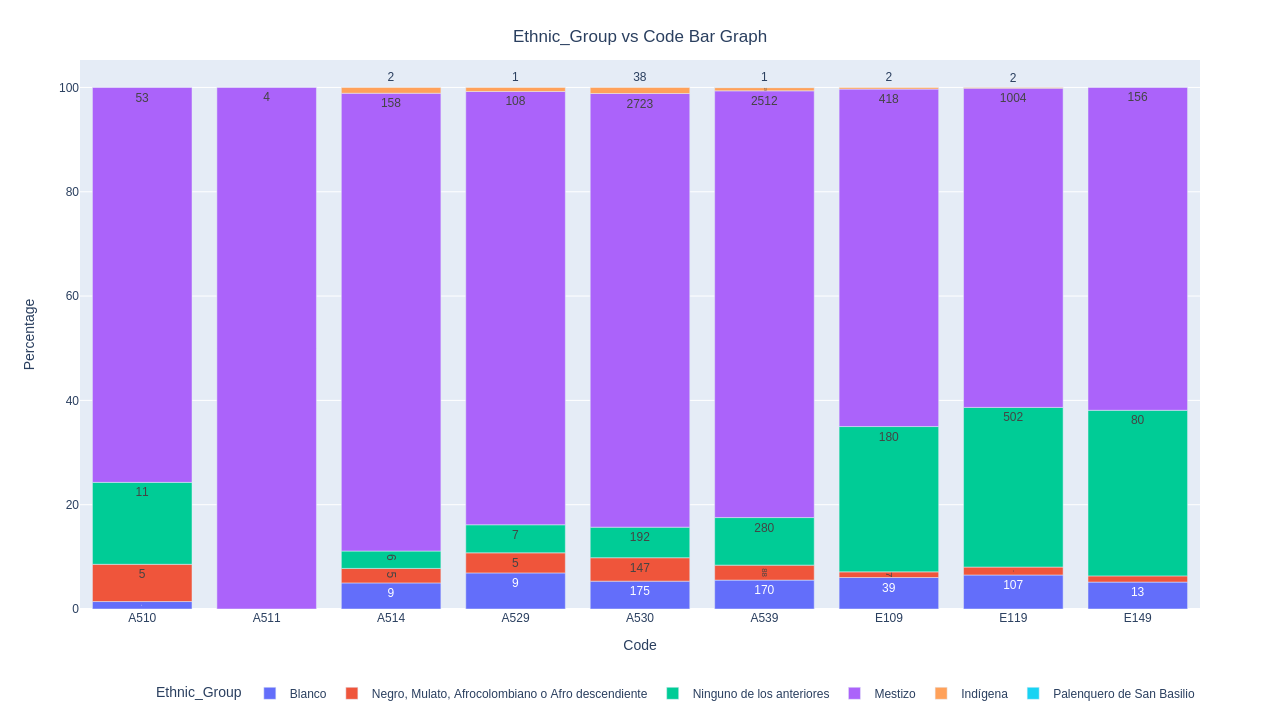

In [19]:
var_of_interest = "Ethnic_Group"

df_analysis = (
    merged_translated[["Nombre", "Code", var_of_interest]]
    .value_counts()
    .to_frame("Count")
)
df_analysis["Percentage"] = (df_analysis.Count / sum(df_analysis.Count) * 100).round(2)
df_analysis.sort_values(["Code", "Count"], ascending=False)

df_analysis = df_analysis.reset_index()
df_analysis["Percentage"] = df_analysis.apply(
    lambda row: percentage_for_code(df_analysis, row), axis=1
)
df_analysis = df_analysis.sort_values(["Code"])

fig = px.bar(
    df_analysis,
    x="Code",
    y=["Percentage"],
    color=var_of_interest,
    text=df_analysis["Count"],
    labels={
        "value": "Percentage",
    },
    category_orders={"Code": sorted(list(df_analysis.Code.unique()))},
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.18,
        xanchor="right",
        x=1,
    ),
    xaxis={"categoryorder": "category ascending"},
    title={
        "text": f"{var_of_interest} vs Code Bar Graph",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


There seems to be more missing/unknown data for patients suffering from diabetes compared to syphilis.

## Residential Area vs Code Bar Graph

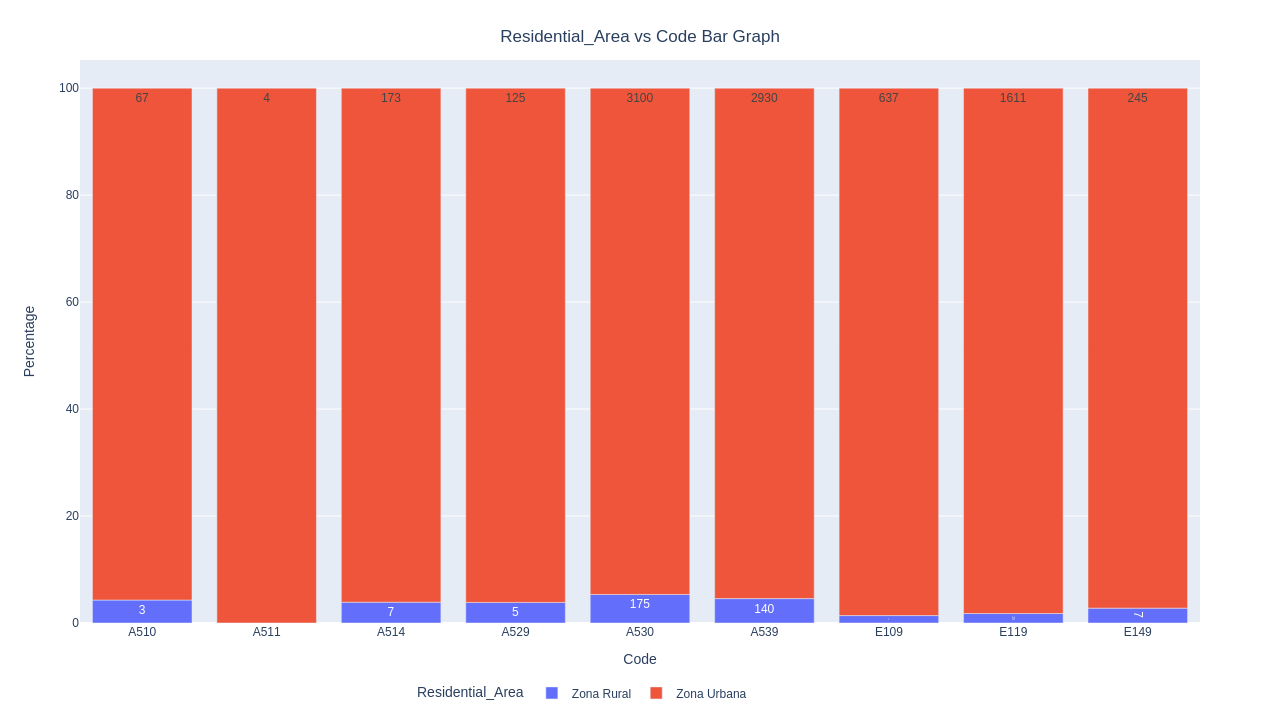

In [20]:
var_of_interest = "Residential_Area"

df_analysis = (
    merged_translated[["Nombre", "Code", var_of_interest]]
    .value_counts()
    .to_frame("Count")
)
df_analysis["Percentage"] = (df_analysis.Count / sum(df_analysis.Count) * 100).round(2)
df_analysis.sort_values(["Code", "Count"], ascending=False)

df_analysis = df_analysis.reset_index()
df_analysis["Percentage"] = df_analysis.apply(
    lambda row: percentage_for_code(df_analysis, row), axis=1
)
df_analysis = df_analysis.sort_values(["Code"])

fig = px.bar(
    df_analysis,
    x="Code",
    y=["Percentage"],
    color=var_of_interest,
    text=df_analysis["Count"],
    labels={
        "value": "Percentage",
    },
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="right",
        x=0.6,
    ),
    xaxis={"categoryorder": "category ascending"},
    title={
        "text": f"{var_of_interest} vs Code Bar Graph",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


There doesn't seem to be a distinction for both diseases between people living in rural areas comapred to those living in urban zones.

## Marital Status vs Code Bar Graph

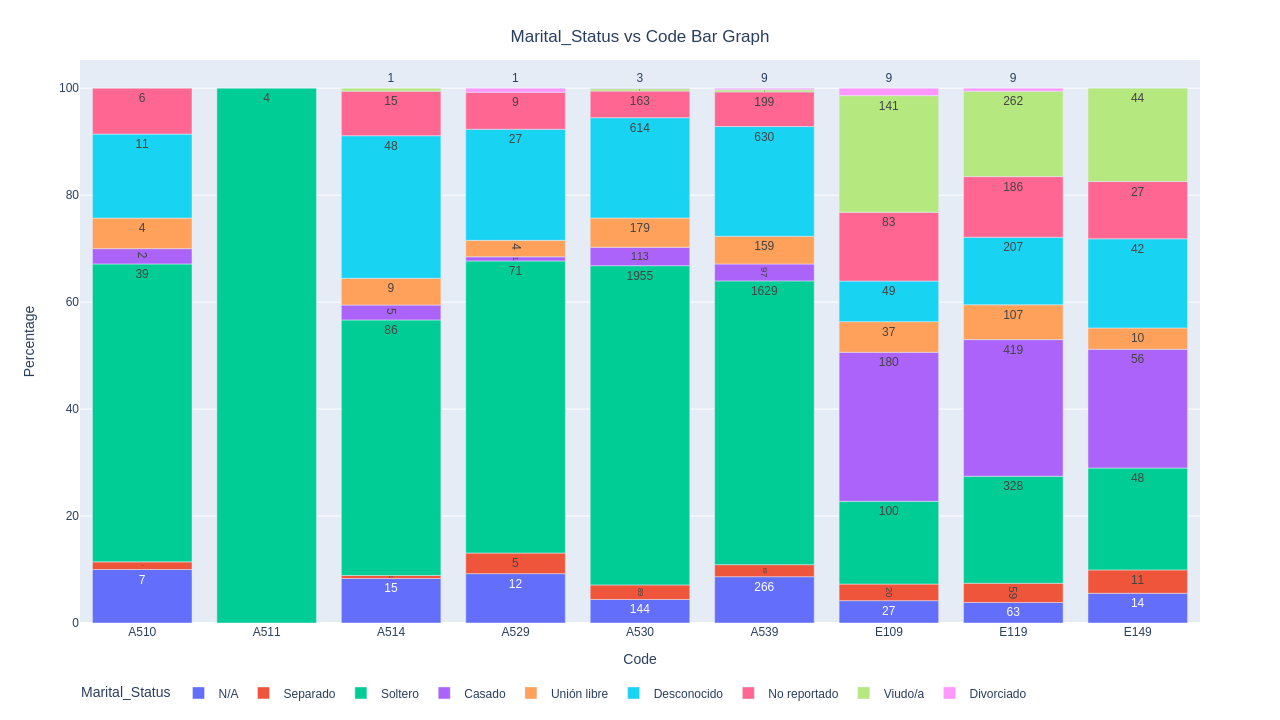

In [21]:
var_of_interest = "Marital_Status"

df_analysis = (
    merged_translated[["Nombre", "Code", var_of_interest]]
    .value_counts()
    .to_frame("Count")
)
df_analysis["Percentage"] = (df_analysis.Count / sum(df_analysis.Count) * 100).round(2)
df_analysis.sort_values(["Code", "Count"], ascending=False)

df_analysis = df_analysis.reset_index()
df_analysis["Percentage"] = df_analysis.apply(
    lambda row: percentage_for_code(df_analysis, row), axis=1
)
df_analysis = df_analysis.sort_values(["Code"])

fig = px.bar(
    df_analysis,
    x="Code",
    y=["Percentage"],
    color=var_of_interest,
    text=df_analysis["Count"],
    labels={
        "value": "Percentage",
    },
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="right",
        x=0.85,
    ),
    xaxis={"categoryorder": "category ascending"},
    title={
        "text": f"{var_of_interest} vs Code Bar Graph",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


According to literature, the lack of a steady relationship makes it easier to contract syphilis. This seems to also be reflected in our data, whereas diabetes has a more even distribution of people in different marital conditions. Interestingly enough, there also seems to be proportionally more widows and widowers who suffer diabetes compared to those suffering from syphilis.

## Blood Type vs Code Bar Graph

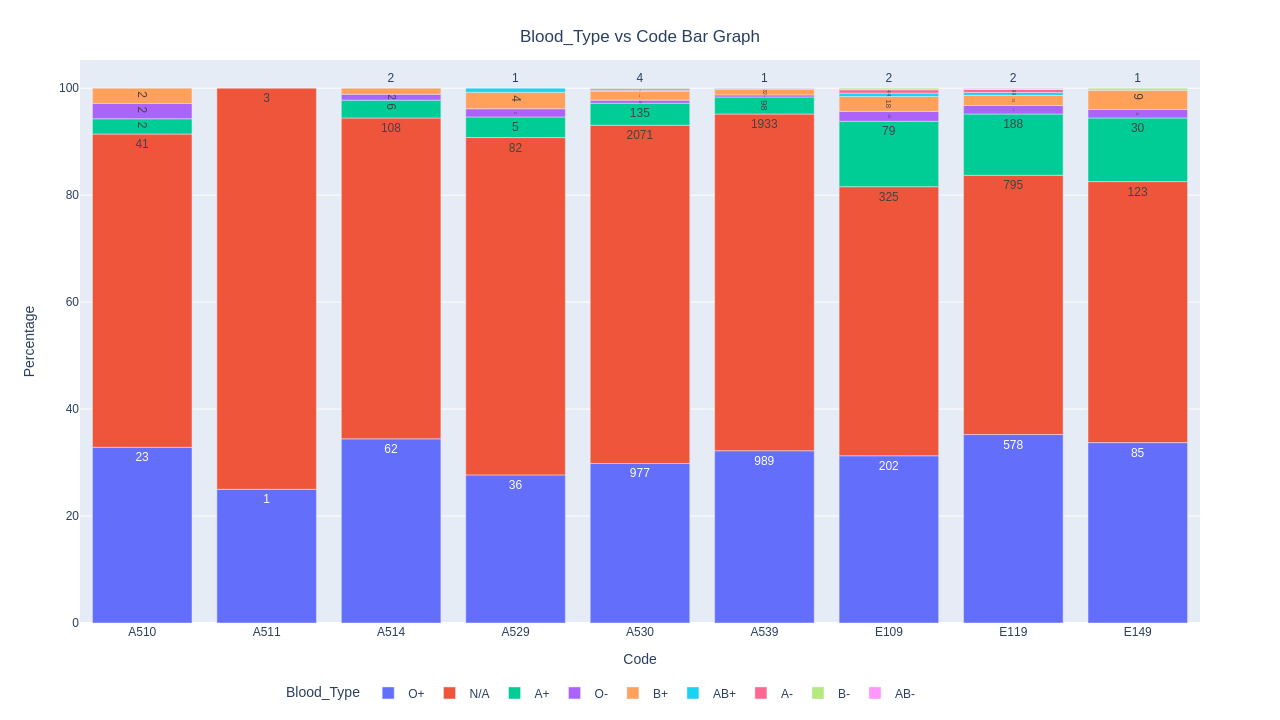

In [22]:
var_of_interest = "Blood_Type"

df_analysis = (
    merged_translated[["Nombre", "Code", var_of_interest]]
    .value_counts()
    .to_frame("Count")
)
df_analysis["Percentage"] = (df_analysis.Count / sum(df_analysis.Count) * 100).round(2)
df_analysis.sort_values(["Code", "Count"], ascending=False)

df_analysis = df_analysis.reset_index()
df_analysis["Percentage"] = df_analysis.apply(
    lambda row: percentage_for_code(df_analysis, row), axis=1
)
df_analysis = df_analysis.sort_values(["Code"])

fig = px.bar(
    df_analysis,
    x="Code",
    y=["Percentage"],
    color=var_of_interest,
    text=df_analysis["Count"],
    labels={
        "value": "Percentage",
    },
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="right",
        x=0.75,
    ),
    xaxis={"categoryorder": "category ascending"},
    title={
        "text": f"{var_of_interest} vs Code Bar Graph",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / f"{var_of_interest.lower()}_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


Blood type does not seem to be a variable that affects the possibility of contracting syphilis or developing diabetes.

## Sociodemographic Data Summary File

Let's build a summary dictionary of these variables, and save it to disk

In [23]:
# Utility function that will help us to store the data as string
def convert_dict_values_to_string(dictionary: dict) -> dict:
    dictionary_copy = dictionary.copy()
    for key in list(dictionary_copy.keys()):
        if isinstance(dictionary_copy[key], dict):
            dictionary_copy[key] = convert_dict_values_to_string(dictionary_copy[key])
        elif isinstance(dictionary_copy[key], list):
            dictionary_copy[key] = [str(val) for val in dictionary_copy[key]]
        else:
            dictionary_copy[key] = str(dictionary_copy[key])
    return dictionary_copy


socio_dict = {}
# First let's add the age
socio_dict["Edad"] = {}
for code in merged_translated.Code.unique():
    socio_dict["Edad"]
    socio_dict["Edad"][code] = boxplot_stats(
        merged_translated[merged_translated.Code == code].Age.values
    )[0]
    if "fliers" in socio_dict["Edad"][code]:
        socio_dict["Edad"][code]["fliers"] = list(
            np.unique(socio_dict["Edad"][code]["fliers"])
        )

# Now the categorical features
variables = [
    "Gender",
    "Marital_Status",
    "Residential_Area",
    "Ethnic_Group",
    "Blood_Type",
]

for var_of_interest in variables:
    df_analysis = (
        merged_translated[["Nombre", "Code", var_of_interest]]
        .value_counts()
        .to_frame("Count")
    )
    df_analysis["Percentage"] = (
        df_analysis.Count / sum(df_analysis.Count) * 100
    ).round(2)
    df_analysis.sort_values(["Code", "Count"], ascending=False)

    df_analysis = df_analysis.reset_index()
    df_analysis["Percentage"] = df_analysis.apply(
        lambda row: percentage_for_code(df_analysis, row), axis=1
    )
    df_analysis = df_analysis.sort_values(["Code"])
    df_analysis[var_of_interest] = df_analysis[var_of_interest].apply(strip_accents)

    socio_dict[eng_spa_dict[var_of_interest]] = (
        df_analysis.pivot(index="Code", columns=var_of_interest, values="Percentage")
        .fillna(0)
        .T.to_dict()
    )
with open(summary_files_save_path / "sociodemographic_summary.json", "w") as out_file:
    json.dump(
        convert_dict_values_to_string(socio_dict), out_file, indent=4, sort_keys=True
    )


# Target Feature Class Distribution

Let's check our taget feature distribution

In [24]:
name = notas[["Nombre", "Código"]].value_counts().to_frame("Count")
name["Percentage"] = (name.Count / sum(name.Count) * 100).round(2)
name


,,Count,Percentage
Nombre,Código,,
"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O TARDIA",A530,60587,43.22
"SIFILIS, NO ESPECIFICADA",A539,47408,33.82
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MENCION DE COMPLICACION,E119,17439,12.44
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCION DE COMPLICACION,E109,6278,4.48
"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION DE COMPLICACION",E149,2808,2.00
OTRAS SIFILIS SECUNDARIAS,A514,2614,1.86
"SIFILIS TARDIA, NO ESPECIFICADA",A529,1970,1.41
SIFILIS GENITAL PRIMARIA,A510,977,0.70
SIFILIS PRIMARIA ANAL,A511,94,0.07


After the data cleanup, we only have less than 1% for two of the 9 classes, representing a total of ~1000 samples of the ~150,000 in our dataset.
We can't easily create a prediction algorithm out of these small number of samples, so let's either drop them or merge them into similar categories.

## Classes merge

Let's try merging A510 and A511 with A514, as they all belong to the [A51 Early syphilis](https://icd.who.int/browse10/2019/en#/A51) ICD-10 denomination, indicating they share symptoms. The equivalent Spanish name for this category is [Sífilis precoz](http://ais.paho.org/classifications/chapters/CAP01.html?zoom_highlight=a51).

We could also treat A529 as part of A539, in order to reduce the number of classes without losing track of the important subcategories we already have.

In [25]:
from utils.preprocessing_utils import merge_classes

notas = merge_classes(notas)
name = notas[["Nombre", "Código"]].value_counts().to_frame("Count")
name["Percentage"] = (name.Count / sum(name.Count) * 100).round(2)
name


,,Count,Percentage
Nombre,Código,,
"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O TARDIA",A530,60587,43.22
"SIFILIS, NO ESPECIFICADA",A539,49378,35.23
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MENCION DE COMPLICACION,E119,17439,12.44
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCION DE COMPLICACION,E109,6278,4.48
SIFILIS PRECOZ,A51,3685,2.63
"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION DE COMPLICACION",E149,2808,2.00


# Feature Engineering

## Word count

According to the [CDC](https://www.cdc.gov/std/syphilis/stdfact-syphilis-detailed.htm), primary syphilis is characterized by a chancre mark where the disease enters the body. There is also a possibility of having extra sores in your body, but there does not seem to be any difference per se in the development of its condition based on where the disease started. Another clear indication of syphilis is Saber shin (pierna/tibia en sable).
There is also a reduction in cognitive abilities for patients who have been suffering of syphilis for some time, and this can be tested for using a simple test called the [Clock Drawing Test](https://www2.gov.bc.ca/assets/gov/health/practitioner-pro/bc-guidelines/cogimp-clock-drawing-test.pdf), or [Test del Reloj](https://www.sanitas.es/sanitas/seguros/es/particulares/biblioteca-de-salud/tercera-edad/demencias/test-reloj.html) in Spanish.

Additionally, a main characteristic of primary syphilis seems to be chancres, as well as sores for both Primary and Secondary Syphilis, making a case for creating a new numerical variable called "chancres". Another main characteristic of Syphilis is the push to use preservatives in order to reduce the possibility of other people being infected as well, which could help differentiate between Syphilis and Diabetes.

Other related keywords we can try is genital, skin (lesions), headache, HIV, serology, hepatitis, and specific tests performed on the patients.

In [26]:
notas_eda = notas.copy()
words_to_check = [
    "chancro",
    "llaga",
    "preservativo",
    "sifili",
    "asintoma",
    "placa",
    r"(test.*reloj)",
    "sable",
    "penici",
    "antibio",
    "genital",
    "piel",
    "lesion",
    "macula",
    "cabeza",
    "vih",
    "FTA-ABS",
    "serolo",
    "hepatitis",
    "VDRL",
    "RPR",
]
aggregate_dict = {}
for word in words_to_check:
    notas_eda[word] = notas_eda.Plan.str.lower().str.count(word.lower())
    notas_eda.loc[notas_eda[word] > 1, word] = 1
    aggregate_dict[word] = ["sum"]
aggregate_dict["Nombre"] = ["count"]
notas_eda = notas_eda.groupby(["Nombre", "Código"])[
    words_to_check + ["Nombre"]
].aggregate(aggregate_dict)

for word in words_to_check:
    notas_eda.loc(axis=1)[word, "%"] = (
        notas_eda.loc(axis=1)[word, "sum"]
        / notas_eda.loc(axis=1)["Nombre", "count"]
        * 100
    ).round(2)
with pd.option_context("display.max_columns", None):
    display(notas_eda.sort_index(axis=1).sort_values(by=["Código"]))


(test.*reloj)        \
                                                                      %   sum   
Nombre                                             Código                       
SIFILIS PRECOZ                                     A51             4.91   181   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530            2.91  1761   
SIFILIS, NO ESPECIFICADA                           A539            1.71   845   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109            1.47    92   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119            1.32   230   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149            1.28    36   

                                                          FTA-ABS     Nombre  \
                                                                % sum  count   
Nombre                                             Código                      
SIFILIS PRECOZ                                     A51       0.00   0   3685   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530      0.02  11  60587   
SIFILIS, NO ESPECIFICADA                           A539      0.06  29  49378   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109      0.02   1   6278   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119      0.00   0  17439   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149      0.00   0   2808   

                                                             RPR        VDRL  \
                                                               %   sum     %   
Nombre                                             Código                      
SIFILIS PRECOZ                                     A51      8.06   297  0.54   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530     8.74  5295  0.78   
SIFILIS, NO ESPECIFICADA                           A539    18.17  8971  0.67   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109     4.64   291  0.33   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119     2.92   510  0.23   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149     3.95   111  0.28   

                                                               antibio       \
                                                           sum       %  sum   
Nombre                                             Código                     
SIFILIS PRECOZ                                     A51      20    0.11    4   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530    475    0.10   58   
SIFILIS, NO ESPECIFICADA                           A539    329    0.06   28   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109     21    2.80  176   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119     40    2.99  522   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149      8    5.38  151   

                                                          asintoma        \
                                                                 %   sum   
Nombre                                             Código                  
SIFILIS PRECOZ                                     A51        5.37   198   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530       3.07  1861   
SIFILIS, NO ESPECIFICADA                           A539       1.51   748   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109       1.85   116   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119       2.44   426   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149       2.35    66   

                                                          cabeza         \
                                                               %    sum   
Nombre                                             Código                 
SIFILIS PRECOZ                                     A51     26.08    961   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530    18.07  10950   
SIFILIS, NO ESPECIFICADA                           A539     9.17   4529   
DIABETES MELLITUSINSULINODEPENDIENTE SI

For diabetes, we tried adding insulin and glucose as words of interest. Ketoacidosis is another relevant word which we can separate into keto and acido to see if we can capture more information.

Other keywords associated with diabetes are: obesity, carbohydrates, overweight, polyphagia, polydipsia, polyurea

In [27]:
notas_eda = notas.copy()
words_to_check = [
    "ampolla",
    "diabet",
    "insulin",
    "gluco",
    "carbo",
    "keto",
    "acido",
    "nutri",
    "diet",
    "dependiente",
    "obes",
    "sobrepeso",
    "polifagia",
    "polidipsia",
    "poliurea",
]
aggregate_dict = {}
for word in words_to_check:
    notas_eda[word] = notas_eda.Plan.str.lower().str.count(word.lower())
    notas_eda.loc[notas_eda[word] > 1, word] = 1
    aggregate_dict[word] = ["sum"]
aggregate_dict["Nombre"] = ["count"]
notas_eda = notas_eda.groupby(["Nombre", "Código"])[
    words_to_check + ["Nombre"]
].aggregate(aggregate_dict)

for word in words_to_check:
    notas_eda.loc(axis=1)[word, "%"] = (
        notas_eda.loc(axis=1)[word, "sum"]
        / notas_eda.loc(axis=1)["Nombre", "count"]
        * 100
    ).round(2)
notas_eda.sort_index(axis=1).sort_values(by=["Código"])
with pd.option_context("display.max_columns", None):
    display(notas_eda.sort_index(axis=1).sort_values(by=["Código"]))


Nombre acido        \
                                                           count     %   sum   
Nombre                                             Código                      
SIFILIS PRECOZ                                     A51      3685  0.41    15   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530    60587  0.92   558   
SIFILIS, NO ESPECIFICADA                           A539    49378  1.70   838   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109     6278  6.90   433   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119    17439  6.46  1126   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149     2808  5.59   157   

                                                          ampolla      carbo  \
                                                                %  sum     %   
Nombre                                             Código                      
SIFILIS PRECOZ                                     A51       0.24    9  3.88   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530      0.38  233  3.26   
SIFILIS, NO ESPECIFICADA                           A539      0.95  471  2.22   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109      2.10  132  3.17   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119      1.29  225  2.07   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149      1.07   30  2.60   

                                                                dependiente  \
                                                            sum           %   
Nombre                                             Código                     
SIFILIS PRECOZ                                     A51      143        1.22   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530    1973        1.44   
SIFILIS, NO ESPECIFICADA                           A539    1094        0.74   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109     199        0.67   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119     361        1.23   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149      73        0.68   

                                                               diabet       \
                                                           sum      %  sum   
Nombre                                             Código                    
SIFILIS PRECOZ                                     A51      45   0.14    5   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530    875   0.26  160   
SIFILIS, NO ESPECIFICADA                           A539    365   0.28  136   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109     42   5.16  324   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119    214   5.55  968   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149     19   6.16  173   

                                                            diet        gluco  \
                                                               %   sum      %   
Nombre                                             Código                       
SIFILIS PRECOZ                                     A51      7.54   278   1.03   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530     8.38  5078   1.08   
SIFILIS, NO ESPECIFICADA                           A539     7.71  3809   1.04   
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO... E109    13.35   838  12.68   
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... E119    11.72  2044   5.84   
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... E149    13.35   375   9.44   

                                                                insulin        \
                                                            sum       %   sum   
Nombre                                             Código                       
SIFILIS PRECOZ                                     A51       38    0.03     1   
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ... A530     652    0.09    56   
SIFILIS, NO ESPECIFICADA                           A539     512   

- There does not seem to be many mentions of chancre (chancro) or sore (llaga/placa)
- Ulcer (ulcera) does seem to be more common in patients with diabetes, although it still is negligible.
- Saber (sable) seems to be able to help differentiate for all but 1 types of syphilis against diabetes.
- asintoma seems to be useful for separating other secondary syphilis from the rest of the diseases.
- There does seem to be a significant difference between the times the word preservative (preservativo) is used between Syphilis and Diabetes.
- insulin seems like a good choice for separating E109 from the rest.
- acido, keto and diet seem to also help differentiate between syphilis and diabetes.
- Using 'diabet' and 'sifili' could help differentiate between the diagnoses of Diabetes and Syphilis.

Let's select a few of these features based on our current results and compared with what was found in literature in our project report.

In [28]:
from utils.preprocessing_utils import word_count_feat_engineering

notas = word_count_feat_engineering(notas)
with pd.option_context("display.max_columns", None):
    display(notas.head(10))


,IDRecord,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,45038.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40391.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,106350.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,105840.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACION Se brinda retroalimentacion con rel...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,188030.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,1. Continuar TAR con: ABC/3TC+EFV. 2. Tomar l...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
6,41590.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,a) Se continua manejo iniciado 19/02/2020 a AB...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
7,111487.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,Control segun frecuencias,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,69603.0,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,Se realiza control de enfermeria el 16 de OCTU...,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0
9,69563.0,A51,SIFILIS PRECOZ,Confirmado Repetido,1. TRATAMIENTO TDF/FTC/EFV 2. PROFILAXIS:NO...,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0


## Lab results analysis

Let's take a look at the laboratory dataset. AS this dataset is mainly a time series dataset, let's see what features we can obtai nthat we can then extrapolate to our main patient dataset.

In [29]:
# Let's convert the date to a datetime format
merged_lab["Fecha"] = pd.to_datetime(merged_lab["Fecha"])
merged_lab


,IDRecord,Codigo,Nombre_lab,Fecha,Valor,fecha,Código,Nombre
0,95627,902045,tiempo de protrombina (pt),2022-02-22 18:43:00,NaN,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
1,95627,902049,tiempo de tromboplastina parcial (ptt),2022-02-22 18:43:00,37.1,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
2,95627,903803,albumina test,2022-02-22 18:43:00,4.0,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
3,95627,903809,bilirrubina test,2022-02-22 18:43:00,NaN,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
4,95627,902209,"hemograma iii (hemoglobina, hematocrito, recue...",2022-02-22 18:43:00,NaN,2022-02-22 18:43:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
...,...,...,...,...,...,...,...,...
189470,72152,906915,serologia (prueba no treponemica) test,2020-02-28 00:00:00,16.0,2020-02-28 00:00:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
189471,72152,908832,vih test,2020-02-28 00:00:00,20.0,2020-02-28 00:00:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
189472,39161,906915,serologia (prueba no treponemica) test,2020-03-17 00:00:00,16.0,2020-03-17 00:00:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."
189473,39382,898034,coloracion test,2020-08-01 00:00:00,NaN,2020-08-01 00:00:00,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O..."


## Average and max difference in dates between each exam

Let's try to calculate the maximum and average difference between the first and last exam each patient had

In [30]:
merged_lab_date_calc = merged_lab.sort_values(by=["IDRecord", "Fecha"]).copy()
merged_lab_date_calc["date_diff"] = (
    merged_lab_date_calc[["IDRecord", "Fecha"]].groupby("IDRecord").diff()
)
merged_lab_datediff = (
    merged_lab_date_calc[["IDRecord", "date_diff"]]
    .groupby("IDRecord")
    .agg([np.nanmean, np.nanmax])
)
merged_lab_datediff.columns = [
    "_".join(col) for col in merged_lab_datediff.columns.values
]
merged_lab_datediff = merged_lab_datediff.rename(
    columns={"date_diff_nanmean": "date_diff_mean", "date_diff_nanmax": "date_diff_max"}
)
merged_lab_datediff["date_diff_max"] = merged_lab_datediff["date_diff_max"].dt.days
merged_lab_datediff["date_diff_mean"] = merged_lab_datediff["date_diff_mean"].dt.days
merged_lab = merged_lab.drop(
    columns=["date_diff_mean", "date_diff_max"], errors="ignore"
).merge(
    merged_lab_datediff[["date_diff_mean", "date_diff_max"]].reset_index(),
    how="left",
    on="IDRecord",
)


### Mean date difference

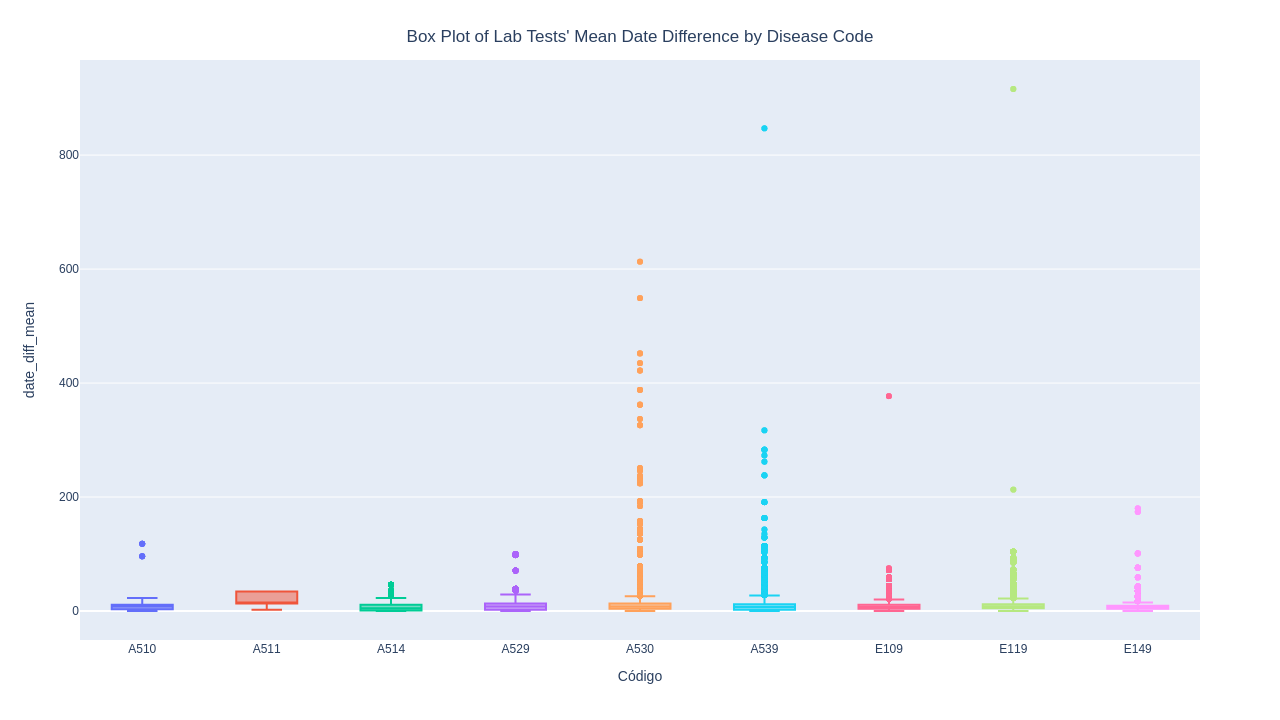

In [31]:
fig = px.box(
    merged_lab.sort_values(by=["Código"]),
    y="date_diff_mean",
    x="Código",
    color="Código",
    # notched=True, # used notched shape
)
fig.update_layout(
    showlegend=False,
    title={
        "text": "Box Plot of Lab Tests' Mean Date Difference by Disease Code",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)
fig.write_image(
    str(figure_save_path / "lab_date_mean_diff.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


### Max date difference

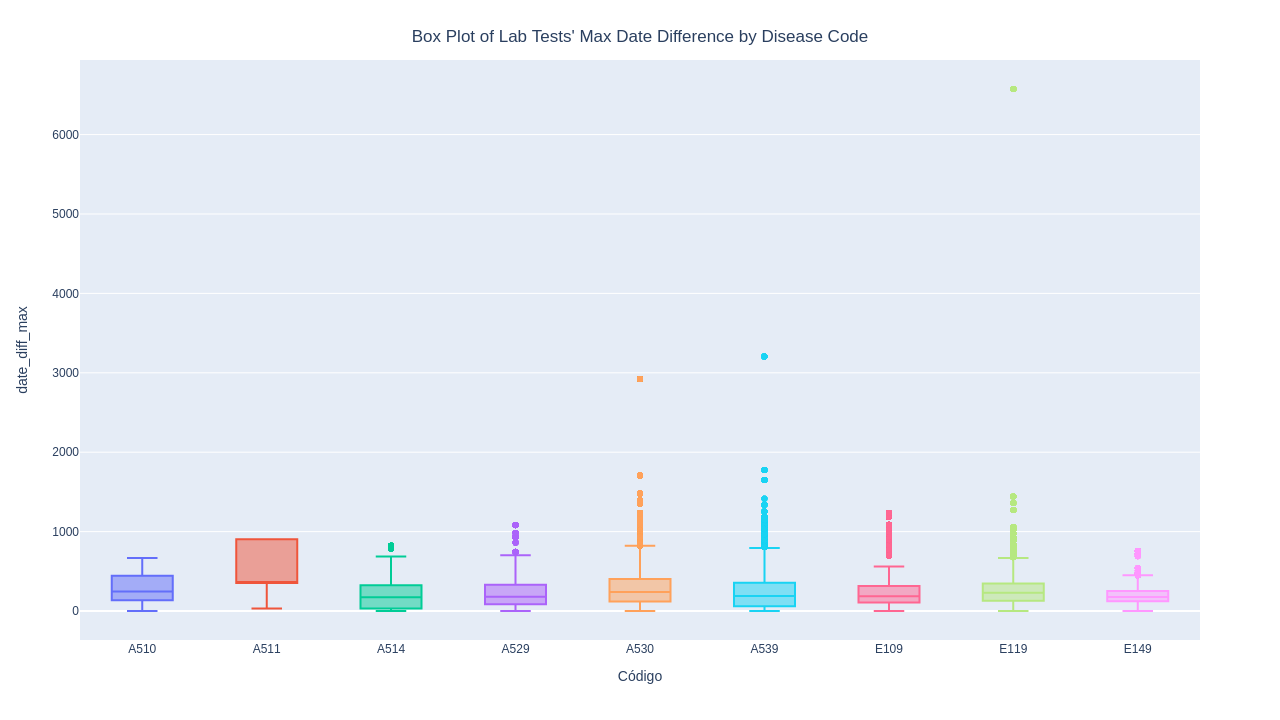

In [32]:
fig = px.box(
    merged_lab.sort_values(by=["Código"]),
    y="date_diff_max",
    x="Código",
    color="Código",
    # notched=True, # used notched shape
)
fig.update_layout(
    showlegend=False,
    title={
        "text": "Box Plot of Lab Tests' Max Date Difference by Disease Code",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)
fig.write_image(
    str(figure_save_path / "lab_date_max_diff.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


### Disease-related tests

Supported by what we foud in our literature review for our project report, we can check if there are specific disease-related tests performed on the patients. E.g., as we know that HIV or a high level of lymphocites can be more common in patients with Syphilis, we can look specifically for those. Similarly, glucose tests are more common in patients with Diabetes.

In [33]:
disease_tests = disease_tests_list()
disease_tests


[('hepatitis|hepat|glutamic|bilirrub', 'liver_damage'),
 ('hemo|hema', 'hematic_info'),
 ('bacilo|bacter|colora|gram|tinc', 'bacterias'),
 ('tiroi|protro|tirox', 'hormones'),
 ('herpes|tuberc', 'other_diseases'),
 ('album|creat|ureico|urico|uro|orina', 'kidney_damage'),
 ('colest|trigli|plaqu|protrom|trombo', 'heart_damage'),
 ('calcio|fofs|pot', 'minerals'),
 ('leuco|linfo|cd3|cd4|cd8|anticuerpo|antigen|neutrof', 'white_cells'),
 ('deficiencia|vih|immuno', 'vih'),
 ('ayun|gluco|glico', 'diabetes_tests'),
 ('trepo|anal|virus|viral', 'syphilis_tests')]

Let's use it on our data to see what types of exams were performed on each patient.

In [34]:
df_id_record = merged_lab.IDRecord.drop_duplicates().to_frame("IDRecord")
for test in disease_tests:
    df_test_count = (
        merged_lab.loc[
            merged_lab.Nombre_lab.str.contains(test[0], case=False, regex=True),
            ["IDRecord"],
        ]
        .value_counts()
        .to_frame(f"{test[1]}_count")
    )
    df_test_max = (
        merged_lab.loc[
            merged_lab.Nombre_lab.str.contains(test[0], case=False, regex=True),
            ["IDRecord", "Valor"],
        ]
        .groupby("IDRecord")
        .max()
        .reset_index()
        .rename(columns={"Valor": f"{test[1]}_max"})
    )  # .value_counts().to_frame()
    df_id_record = df_id_record.merge(df_test_count, on="IDRecord", how="left").merge(
        df_test_max, on="IDRecord", how="left"
    )
df_id_record


,IDRecord,liver_damage_count,liver_damage_max,hematic_info_count,hematic_info_max,bacterias_count,bacterias_max,hormones_count,hormones_max,other_diseases_count,...,minerals_count,minerals_max,white_cells_count,white_cells_max,vih_count,vih_max,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max
0,95627,5.0,26.7,3.0,46.4,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,125572,14.0,68.9,5.0,34.3,2.0,NaN,1.0,NaN,NaN,...,NaN,NaN,4.0,80.50,1.0,NaN,1.0,109.7,1.0,80.5
2,55788,27.0,77175.0,11.0,42.9,6.0,NaN,1.0,1.05,NaN,...,NaN,NaN,11.0,74.91,4.0,40.0,6.0,99.1,9.0,16.0
3,113766,16.0,29.9,4.0,37.5,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,3.0,67.84,1.0,NaN,1.0,89.0,2.0,NaN
4,44596,14.0,169.0,7.0,45.6,2.0,NaN,1.0,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,3.0,95.4,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,87491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
5948,72152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,20.0,NaN,NaN,1.0,16.0
5949,39161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0
5950,39382,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Let's merge the data with the main dataset
merged = merged.drop(
    columns=df_id_record.drop(columns=["IDRecord"]).columns, errors="ignore"
).merge(df_id_record, on="IDRecord", how="left")
for column in df_id_record.drop(columns=["IDRecord"]).columns:
    merged[column] = merged[column].fillna(0)
merged


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,...,minerals_count,minerals_max,white_cells_count,white_cells_max,vih_count,vih_max,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


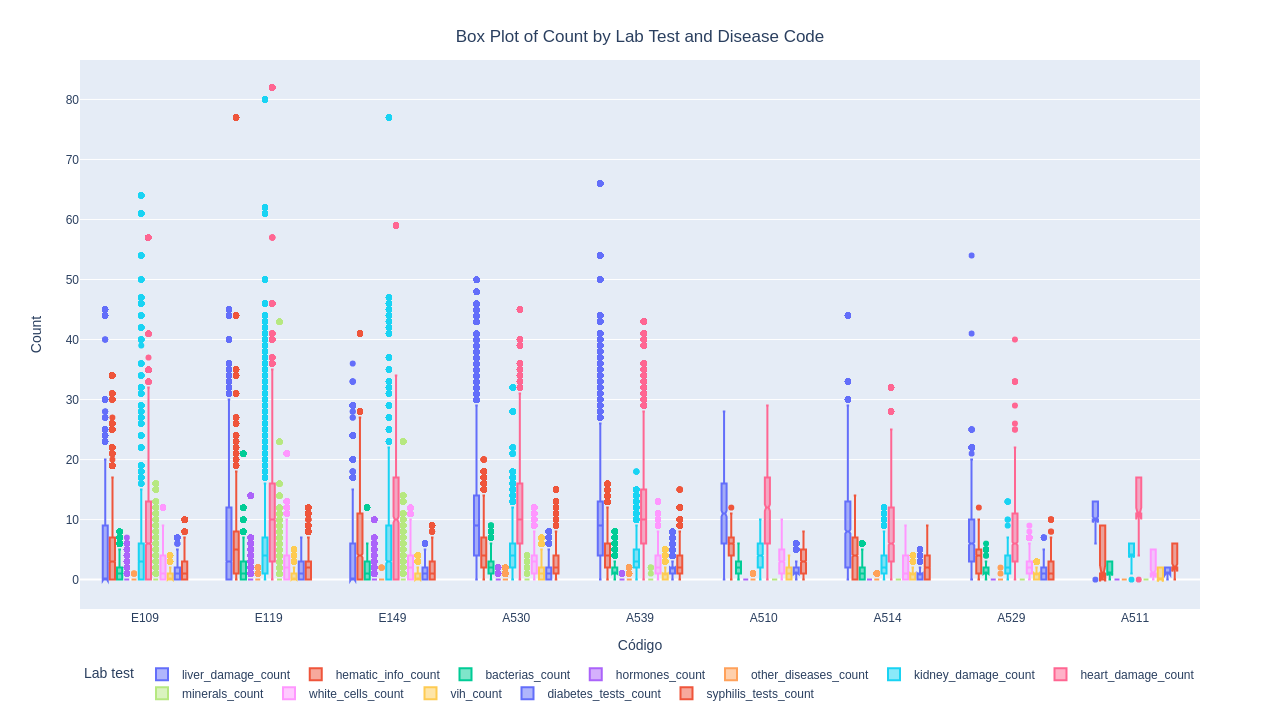

In [36]:
merge_vars = [f"{test[1]}_count" for test in disease_tests]
disease_melt_df = merged[['IDRecord', 'Código'] + merge_vars].copy()
lab_count_by_lab_test = pd.melt(
    disease_melt_df,
    id_vars=["IDRecord", "Código"],
    value_vars=merge_vars,
)

# Let's remove some outliers so we can get a more readable boxplot
lab_count_by_lab_test = lab_count_by_lab_test[lab_count_by_lab_test.value < 100]

fig = px.box(
    lab_count_by_lab_test,
    y="value",
    x="Código",
    color="variable",
    notched=True,  # used notched shape
    labels={
        "value": "Count",
        "variable": "Lab test",
    },
)

fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=-0.18, xanchor="right", x=1),
    title={
        "text": "Box Plot of Count by Lab Test and Disease Code",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / "lab_count_by_lab_test_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


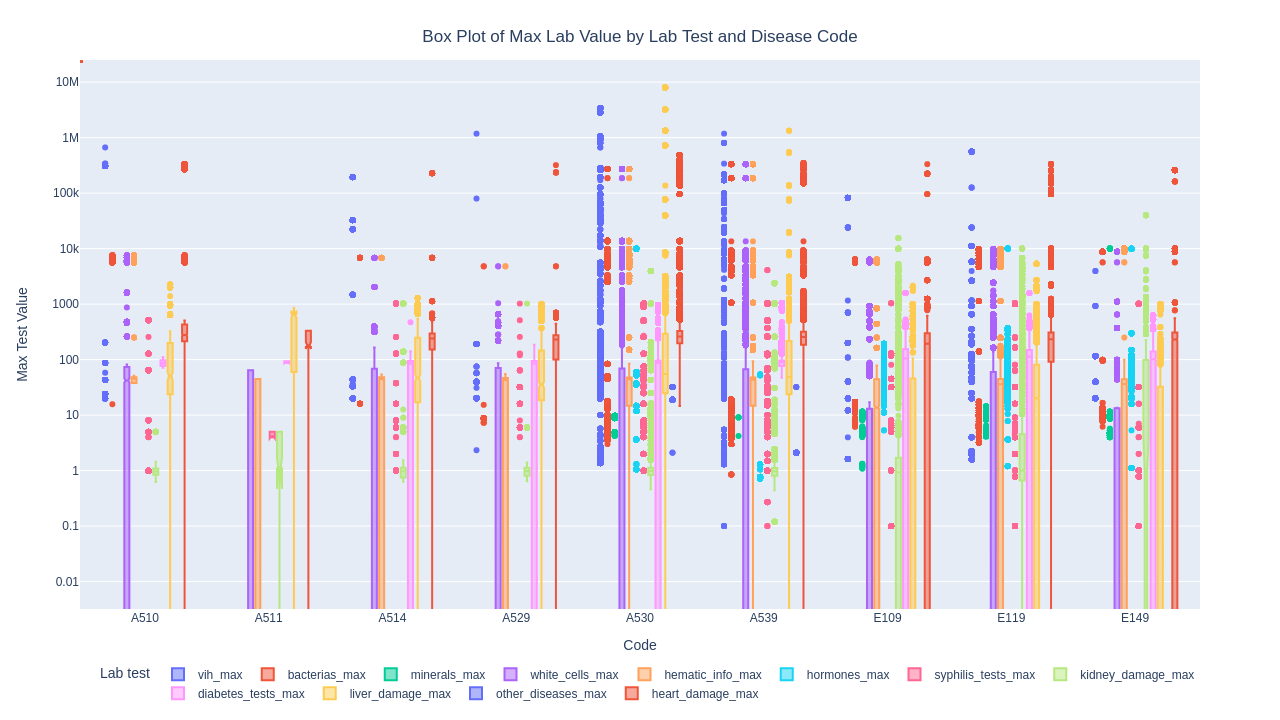

In [37]:
lab_max_by_lab_test = pd.melt(
    merged,
    id_vars=["IDRecord", "Código"],
    value_vars=[f"{test[1]}_max" for test in disease_tests],
).sort_values(by=["Código"])

# Let's remove some outliers so we can get a more readable boxplot
# lab_max_by_lab_test = lab_max_by_lab_test[lab_max_by_lab_test.value < 1000000]

fig = px.box(
    lab_max_by_lab_test,
    y="value",
    x="Código",
    color="variable",
    notched=True,  # used notched shape
    labels={
        "value": "Max Test Value",
        "variable": "Lab test",
        "Código": "Code",
    },
    log_y=True,
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=-0.18, xanchor="right", x=1),
    title={
        "text": "Box Plot of Max Lab Value by Lab Test and Disease Code",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)
fig.write_image(
    str(figure_save_path / f"lab_max_by_lab_test_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


From these results, it seems that the number of kidney-related exams and hormone-related exams were higher for patients with diabetes compared to those with syphilis, while the maximum values of HIV-related exams were higher for patients with syphilis.

### Top lab name and max value performed by patient

Let's now calculate the top lab name, by number of times it was performed on each patient, as well as its max value.

In [38]:
merged_labs = merged_lab.groupby(["IDRecord", "Nombre_lab"])
merged_labs_agg = merged_labs.aggregate(
    {"Valor": [np.nanmean, np.nanmax], "Nombre_lab": "count"}
)
merged_labs_agg.columns = ["_".join(col) for col in merged_labs_agg.columns.values]
merged_labs_agg = merged_labs_agg.rename(
    columns={
        "Nombre_lab": "lab_count",
        "Valor_nanmean": "top_lab_avg_value",
        "Valor_nanmax": "top_lab_max_value",
    }
).reset_index()
merged_labs_agg["top_lab_avg_value"] = merged_labs_agg["top_lab_avg_value"].fillna(0)
merged_labs_agg["top_lab_max_value"] = merged_labs_agg["top_lab_max_value"].fillna(0)
merged_labs_agg

top_lab_test_by_patient = merged_labs_agg.merge(
    merged_labs_agg.loc[
        merged_labs_agg.groupby("IDRecord").Nombre_lab_count.idxmax(),
        ["IDRecord", "Nombre_lab"],
    ]
).rename(columns={"Nombre_lab": "top_lab_name", "Nombre_lab_count": "top_lab_count"})
top_lab_test_by_patient


,IDRecord,top_lab_name,top_lab_avg_value,top_lab_max_value,top_lab_count
0,5,colesterol test,108.333333,150.00,3
1,497,creatinina test,0.630000,0.67,2
2,698,colesterol test,140.266667,226.80,3
3,819,creatinina test,1.410000,1.41,1
4,830,creatinina test,0.540000,0.54,1
...,...,...,...,...,...
5947,204909,colesterol test,103.566667,174.70,3
5948,204937,colesterol test,100.166667,172.50,3
5949,205045,colesterol test,111.700000,176.10,3
5950,205164,colesterol test,127.433333,206.30,3


We get then the top lab name for each patient based on the number of times that lab was prescribed to each patient, with the average and max value reading of each of those lab tests.

Merge the top lab data with the merged DF

In [39]:
merged = merged.drop(
    columns=top_lab_test_by_patient.drop(columns=["IDRecord"]).columns, errors="ignore"
).merge(top_lab_test_by_patient, how="left", on="IDRecord")
merged["top_lab_name"] = merged.top_lab_name.fillna(0)
merged["top_lab_avg_value"] = merged.top_lab_avg_value.fillna(0)
merged["top_lab_max_value"] = merged.top_lab_max_value.fillna(0)
merged["top_lab_count"] = merged.top_lab_count.fillna("NA")
merged


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,...,vih_count,vih_max,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max,top_lab_name,top_lab_avg_value,top_lab_max_value,top_lab_count
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,colesterol test,108.333333,150.0,3.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA


### Number of total lab tests taken by patient

In [40]:
total_lab_count_by_patient = (
    merged_labs_agg.groupby(["IDRecord"])
    .aggregate({"Nombre_lab_count": "sum"})
    .rename(columns={"Nombre_lab_count": "total_Nombre_lab_count"})
)
total_lab_count_by_patient


,total_Nombre_lab_count
IDRecord,
5,8
497,4
698,10
819,3
830,3
...,...
204909,26
204937,27
205045,27


Let's check if there's any relationship between number of tests and the disease class

In [41]:
if "total_Nombre_lab_count" not in merged.columns:
    merged = merged.merge(
        total_lab_count_by_patient, how="left", on="IDRecord"
    )
else:
    merged = merged.drop(columns="total_lab_count").merge(
        total_lab_count_by_patient, how="left", on="IDRecord"
    )
merged["total_lab_count"] = merged.total_Nombre_lab_count.fillna(0)
merged


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,...,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max,top_lab_name,top_lab_avg_value,top_lab_max_value,top_lab_count,total_Nombre_lab_count,total_lab_count
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,colesterol test,108.333333,150.0,3.0,8.0,8.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,...,0.0,0.0,0.0,0.0,0,0.000000,0.0,NA,NaN,0.0


In [42]:
merged[["IDRecord", "total_Nombre_lab_count", "Código"]].sort_values(
    by="total_Nombre_lab_count"
)


,IDRecord,total_Nombre_lab_count,Código
62401,69701,1.0,E119
114510,86433,1.0,A529
114509,86433,1.0,A529
114508,86433,1.0,A529
114507,86433,1.0,A529
...,...,...,...
140166,205170,NaN,E149
140167,205218,NaN,A539
140168,205227,NaN,A530
140169,205253,NaN,E109


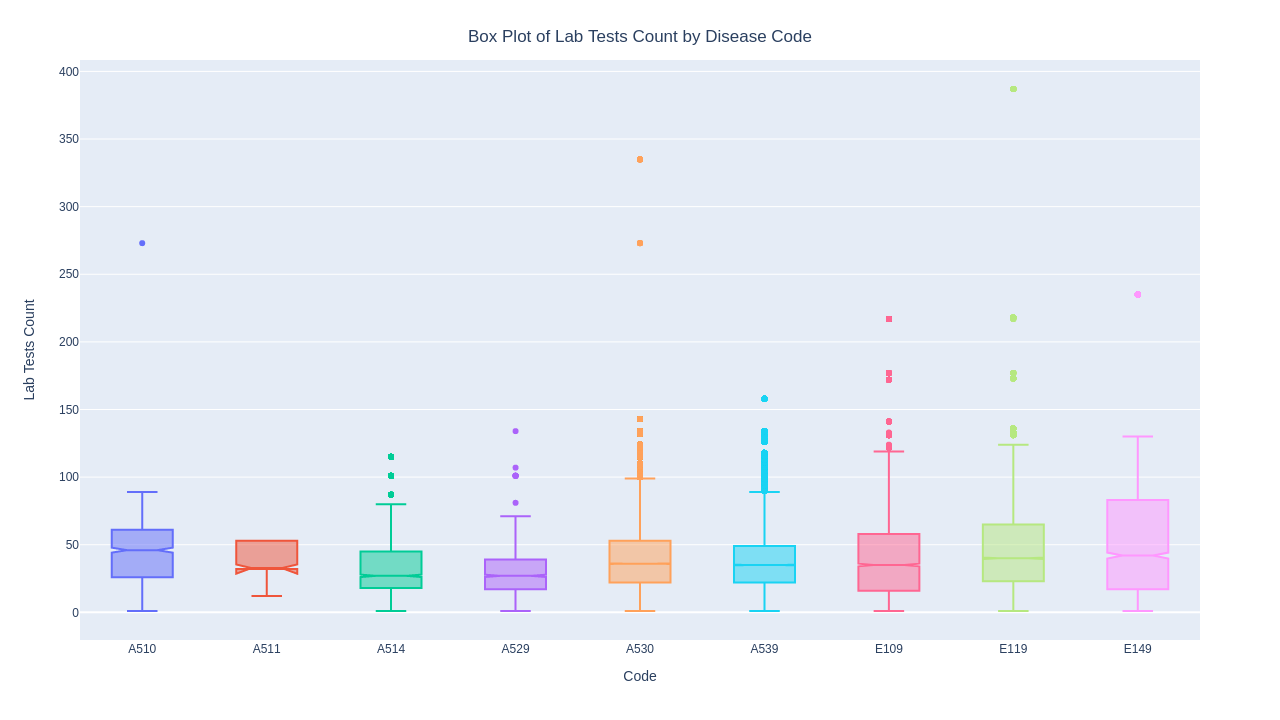

In [43]:
fig = px.box(
    merged.sort_values(by=["Código"]),
    y="total_Nombre_lab_count",
    x="Código",
    color="Código",
    notched=True,  # used notched shape
    labels={
        "total_Nombre_lab_count": "Lab Tests Count",
        "Código": "Code",
    },
)

fig.update_layout(
    showlegend=False,
    title={
        "text": "Box Plot of Lab Tests Count by Disease Code",
        # 'y':0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.write_image(
    str(figure_save_path / "lab_test_count_vs_code_boxplot.png"),
    width=fig_width,
    height=fig_height,
    scale=2,
)
fig.show()


From the boxplot we can see what it seems to be a higher variability in the data for diabetes-related diseases.

## Lab Data Summary File

Let's build the summary file for labs now

In [44]:
lab_dict = {}

# Let's add some boxplot summary data from labs
for var in ["total_lab_count"] + [
    f"{value[1]}_count" for value in disease_tests_list()
]:
    lab_dict[var] = {}
    for code in merged["Código"].unique():
        lab_dict[var][code] = boxplot_stats(
            merged[merged["Código"] == code][var].values
        )[0]
        if "fliers" in lab_dict[var][code]:
            lab_dict[var][code]["fliers"] = list(
                np.unique(lab_dict[var][code]["fliers"])
            )

for var in ['date_diff_mean', 'date_diff_max']:
    lab_dict[var] = {}
    for code in merged_lab["Código"].unique():
        lab_dict[var][code] = boxplot_stats(
            merged_lab[merged_lab["Código"] == code][var].fillna(0).values
        )[0]
        if "fliers" in lab_dict[var][code]:
            lab_dict[var][code]["fliers"] = list(
                np.unique(lab_dict[var][code]["fliers"])
            )

# Save it to file
with open(summary_files_save_path / "lab_summary.json", "w") as out_file:
    json.dump(
        convert_dict_values_to_string(lab_dict), out_file, indent=4, sort_keys=True
    )


## Notas Data Summary File

In [ ]:
notas_dict = {}
for code in notas["Código"].unique():
    sentence_list = (
        notas[notas["Código"] == code]
        .Plan.apply(lambda x: remove_characters(remove_stop_words(x), ["-", ","]))
        .str.replace("[0-9]", "", regex=True)
        .to_list()
    )

    vectorizer = TfidfVectorizer(use_idf=True, stop_words=stopwords.words("spanish"))
    tf_idf = vectorizer.fit_transform(sentence_list)
    tf_idf_df = pd.DataFrame(
        tf_idf[0].T.todense(),
        index=vectorizer.get_feature_names_out(),
        columns=["TF-IDF"],
    )
    tf_idf_df = tf_idf_df.sort_values("TF-IDF", ascending=False)
    notas_dict[code] = (
        tf_idf_df.iloc[:10, :]
        .reset_index()
        .rename(columns={"index": "Word"})
        .set_index("Word")
        .to_dict()["TF-IDF"]
    )

with open(summary_files_save_path / "notes_summary.json", "w") as out_file:
    json.dump(
        convert_dict_values_to_string(notas_dict), out_file, indent=4, sort_keys=True
    )
